In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# NAG оптимизатор
class CustomNAG(optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.9, dampening=0.0, weight_decay=0.0, nesterov=True):
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov)
        super(CustomNAG, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            weight_decay = group['weight_decay']
            lr = group['lr']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(p.data, alpha=weight_decay)
                if momentum != 0:
                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer = state['momentum_buffer'] = torch.zeros_like(p.data)
                        momentum_buffer.copy_(d_p)
                    else:
                        momentum_buffer = state['momentum_buffer']
                        momentum_buffer.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p.add_(momentum_buffer, alpha=momentum)
                p.data.add_(d_p, alpha=-lr)

        return loss

In [17]:
# Загрузка и предобработка данных
train_x_df = pd.read_csv('train_x.csv', header=0)
train_y_df = pd.read_csv('train_y.csv', header=0)

# Переименование колонок
train_x_df.columns = ['id'] + [f'feat_{i}' for i in range(90)]
train_y_df.columns = ['id', 'year']

train_x_df = train_x_df.dropna(subset=['id'])
train_y_df = train_y_df.dropna(subset=['id'])

# Сопоставление по ID
train_df = pd.merge(train_x_df, train_y_df, on='id')

X = train_df[[f'feat_{i}' for i in range(90)]].values
y = train_df['year'].values.astype(np.float32)

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# TensorDataset с нормализованными y
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [18]:
# MLP для регрессии
class MusicYearMLP(nn.Module):
    def __init__(self, input_size=90, hidden_sizes=[256, 128, 64], dropout=0.3):
        super(MusicYearMLP, self).__init__()
        layers = []
        prev_size = input_size
        for h in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, h),
                nn.ReLU(),
                nn.BatchNorm1d(h),
                nn.Dropout(dropout)
            ])
            prev_size = h
        layers.append(nn.Linear(prev_size, 1))  # Output: normalized year
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

criterion = nn.MSELoss()

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=100):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch}, batch")
                return train_losses, val_losses
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item() * batch_x.size(0)
        train_loss /= len(train_loader.dataset)

        # Val
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_x.size(0)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        if epoch % 20 == 0:
            print(f'Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')

    return train_losses, val_losses

=== Обучение с Custom NAG ===
Epoch 0: Train Loss 1.2380, Val Loss 0.9214
Epoch 20: Train Loss 0.7231, Val Loss 0.6960
Epoch 40: Train Loss 0.6649, Val Loss 0.6778
Epoch 60: Train Loss 0.6255, Val Loss 0.6648
Epoch 80: Train Loss 0.5967, Val Loss 0.6668

=== Обучение с Adam ===
Epoch 0: Train Loss 0.9838, Val Loss 0.7250
Epoch 20: Train Loss 0.4544, Val Loss 0.7195
Epoch 40: Train Loss 0.3685, Val Loss 0.7245
Epoch 60: Train Loss 0.3211, Val Loss 0.7302
Epoch 80: Train Loss 0.2888, Val Loss 0.7598


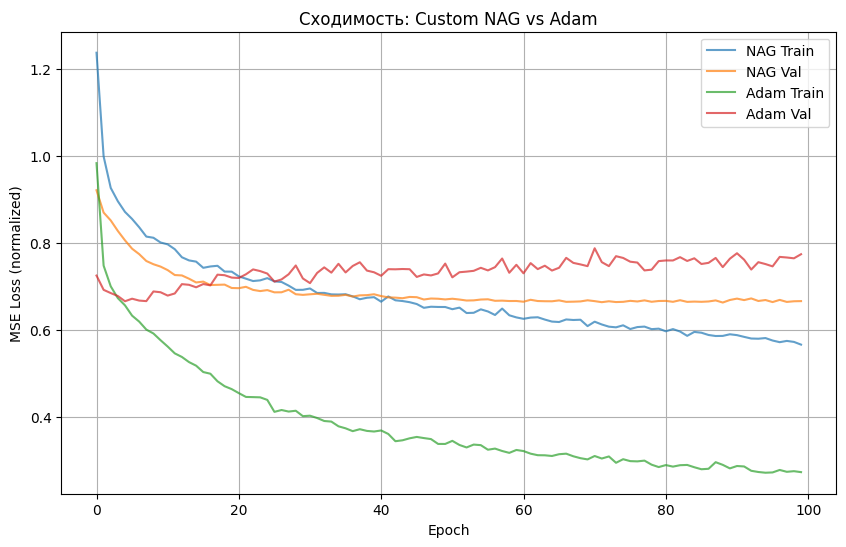

In [19]:
print("=== Обучение с Custom NAG ===")
model_nag = MusicYearMLP()
custom_nag = CustomNAG(model_nag.parameters(), lr=0.001, momentum=0.9)  # Увеличен lr, т.к. y нормализовано
train_losses_nag, val_losses_nag = train_model(model_nag, custom_nag, criterion, train_loader, val_loader, epochs=100)

torch.save(model_nag.state_dict(), 'best_nag.pth')
model_nag.load_state_dict(torch.load('best_nag.pth', weights_only=True))

print("\n=== Обучение с Adam ===")
model_adam = MusicYearMLP()
adam_opt = optim.Adam(model_adam.parameters(), lr=0.001)
train_losses_adam, val_losses_adam = train_model(model_adam, adam_opt, criterion, train_loader, val_loader, epochs=100)

torch.save(model_adam.state_dict(), 'best_adam.pth')
model_adam.load_state_dict(torch.load('best_adam.pth', weights_only=True))

plt.figure(figsize=(10, 6))
plt.plot(train_losses_nag, label='NAG Train', alpha=0.7)
plt.plot(val_losses_nag, label='NAG Val', alpha=0.7)
plt.plot(train_losses_adam, label='Adam Train', alpha=0.7)
plt.plot(val_losses_adam, label='Adam Val', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (normalized)')
plt.title('Сходимость: Custom NAG vs Adam')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Оценка на val
def evaluate(model, loader, criterion, scaler_y):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    with torch.no_grad():
        for batch_x, batch_y_norm in loader:
            outputs_norm = model(batch_x)
            loss_norm = criterion(outputs_norm, batch_y_norm)
            total_loss += loss_norm.item() * batch_x.size(0)

            outputs = scaler_y.inverse_transform(outputs_norm.numpy()).flatten()
            batch_y = scaler_y.inverse_transform(batch_y_norm.numpy()).flatten()
            mae = np.mean(np.abs(outputs - batch_y))
            total_mae += mae * batch_x.size(0)
    n = len(loader.dataset)
    mse_norm = total_loss / n
    mae_orig = total_mae / n
    return mse_norm, mae_orig

nag_mse_norm, nag_mae = evaluate(model_nag, val_loader, criterion, scaler_y)
adam_mse_norm, adam_mae = evaluate(model_adam, val_loader, criterion, scaler_y)

print(f"\n=== Результаты на Val ===")
print(f"Custom NAG: MSE (norm)={nag_mse_norm:.4f}, MAE (years)={nag_mae:.2f}")
print(f"Adam: MSE (norm)={adam_mse_norm:.4f}, MAE (years)={adam_mae:.2f}")

# Предсказания для test
test_x_df = pd.read_csv('test_x.csv', header=0)
test_x_df.columns = [f'feat_{i}' for i in range(90)] + ['id']
test_ids = test_x_df['id'].values
test_features = test_x_df[[f'feat_{i}' for i in range(90)]].values

test_scaled = scaler_x.transform(test_features)

model_nag.eval()
with torch.no_grad():
    test_tensor = torch.tensor(test_scaled, dtype=torch.float32)
    pred_norm = model_nag(test_tensor).squeeze().numpy()

predictions = scaler_y.inverse_transform(pred_norm.reshape(-1, 1)).flatten()
predictions = np.clip(predictions, 1920, 2010).astype(np.int32)

submit_df = pd.DataFrame({'id': test_ids, 'year': predictions})
submit_df.to_csv('submission.csv', index=False)
print(f"\nСабмит сохранен: {len(submit_df)} samples")


=== Результаты на Val ===
Custom NAG: MSE (norm)=0.6662, MAE (years)=6.16
Adam: MSE (norm)=0.7742, MAE (years)=6.32

Сабмит сохранен: 6000 samples
